# Classification of lung and colon cancer histopathological images

## Introduction

Cancer is a condition where cells in a specific part of the body grow and reproduce uncontrollably. The cancerous cells can invade and destroy surrounding healthy tissue, including organs. Cancer cells when observed under a microscope can look different than healthy cells, they can be larger or smaller than usual or they may be abnormal in shape. 

## The dataset

The __[LC25000](https://github.com/tampapath/lung_colon_image_set)__ dataset is an image  dataset of both healthy and cancerous cells from the lung and colon tissues. The dataset includes images that belong to a total of five classes:  
 
1. Lung benign tissue
2. Lung adenocarcinoma
3. Lung squamous cell carcinoma
4. Colon adenocarcinoma
5. Colon benign tissue


The lung and colon sets both include benign tissue and adenocarcinoma images, while the squamous cell carcinoma is only included in the lung set.  
'Benign tissue' suggests that the images are of healthy cells. 'Adenocarcinoma' suggests that the images are of glandular tissue cells (tissue that lines internal organs and releases substances). 'Squamous cell carcinoma' suggests that the images are of squamous cells, which are cells that are flat and thin.

Data augmentation was used to increase the data available for training deep learning models since there is a shortage of data in the clinical field. The total 25000 images that are included in the dataset (5000 from each of the five classes) were generated from 1250 original images(250 from each of the five classes) using the __[Augmentor](https://augmentor.readthedocs.io/en/stable/)__ package. 

An example image from each of the five classes in the dataset:

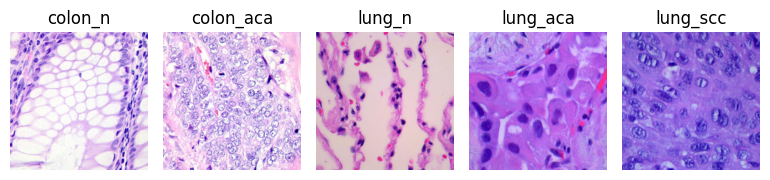

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


#The paths to the first image from each class
samples_paths = ['W:\\uth\\labs\\DL\\lung_colon_image_set\\colon_image_sets\\colon_n\\colonn1.jpeg',
                 'W:\\uth\\labs\\DL\\lung_colon_image_set\\colon_image_sets\\colon_aca\\colonca1.jpeg',
                 'W:\\uth\\labs\\DL\\lung_colon_image_set\\lung_image_sets\\lung_n\\lungn1.jpeg',
                 'W:\\uth\\labs\\DL\\lung_colon_image_set\\lung_image_sets\\lung_aca\\lungaca1.jpeg',
                 'W:\\uth\\labs\\DL\\lung_colon_image_set\\lung_image_sets\\lung_scc\\lungscc1.jpeg'] 

fig, axes = plt.subplots(1, 5, figsize=(7.8, 4))  

samples = []
labels = ['colon_n', 'colon_aca', 'lung_n', 'lung_aca', 'lung_scc']     

for i, sample_path in enumerate(samples_paths):
    sample = Image.open(sample_path)
    samples.append(sample)

    axes[i].imshow(sample)  
    axes[i].set_title(labels[i])
    axes[i].axis('off')  

plt.tight_layout()

plt.show()

As we can see the images appear to be significantly different based on the class they belong in. This could make it easier for the model to classify them, since there are repeating patterns that appear in each of the five subtypes.

## Previous work on the dataset
Many approaches have used hybrid deep learning models with __[one](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9574590)__ of them reaching 99.97% accuracy.

__[Another]((https://arxiv.org/pdf/2206.01088v2.pdf))__, used pre-trained models to identify the cancer types with the results shown below. In this case the metrics presented concern the identification of lung and colon cancer subtypes seperately.

Evaluation of pre-trained CNN models identifying lung cancer.

| Model | Precision | Recall | F1-score | Accuracy | Auroc
|---------|:-----:|:------:|:------:|:------:|:------:|
| VGG16             | 1.0  | 1.0 | 1.0 | 1.0 | 1.0 |
| ResNet50          | 1.0  | 1.0 | 1.0 | 1.0 | 1.0 |
| InceptionV3       | 1.0  | 1.0 | 1.0 | 1.0 | 1.0 |
| InceptionResNetV2 | 1.0  | 1.0 | 1.0 | 1.0 | 1.0 |
| MobileNet         | 1.0  | 1.0 | 1.0 | 1.0 | 1.0 |
| Xception          | 1.0  | 1.0 | 1.0 | 1.0 | 1.0 |
| NASNetMobile      | 1.0  | 1.0 | 1.0 | 1.0 | 0.99|
| DenseNet169       | 1.0  | 1.0 | 1.0 | 1.0 | 1.0 |

Evaluation of pre-trained CNN models identifying colon cancer.

| Model | Precision | Recall | F1-score | Accuracy | Auroc
|---------|:-----:|:------:|:------:|:------:|:------:|
| VGG16             | 1.0  | 1.0 | 1.0 | 1.0 | 1.0 |
| ResNet50          | 1.0  | 1.0 | 1.0 | 1.0 | 1.0 |
| InceptionV3       | 1.0  | 1.0 | 1.0 | 1.0 | 1.0 |
| InceptionResNetV2 | 1.0  | 1.0 | 1.0 | 1.0 | 1.0 |
| MobileNet         | 1.0  | 1.0 | 1.0 | 1.0 | 1.0 |
| Xception          | 1.0  | 1.0 | 1.0 | 1.0 | 1.0 |
| NASNetMobile      | 0.98 | 0.98| 0.98| 0.98| 1.0 |
| DenseNet169       | 1.0  | 1.0 | 1.0 | 1.0 | 1.0 |

Based on the work mentioned above we expect a CNN model to perform well in our specific classification task. 

## Preprocessing

First, we need to import the necessary libraries. These will be used to both modify and process the data as well as visualize the results to gain a better understanding of both the problem and the results.

In [2]:
import os
from PIL import Image
import numpy as np

import matplotlib.pyplot as plt
import keras

import sklearn.metrics
import sklearn.model_selection
from sklearn import model_selection
from sklearn.metrics import confusion_matrix

import seaborn as sns

### Loading the images 

The images are stored in a folder with two subfolders each one of which contains more subfolders. At the lowest level the folders are named after the class that the images belong to. These classes are: 'colon_n', 'colon_aca', 'lung_n', 'lung_aca', 'lung_scc' which refer to 'Colon benign', 'Colon adenocarcinoma', 'Lung benign', 'Lung adenocarcinoma' and 'Lung squamous cell carcinoma' respectively.

Here we can choose the number of images that will be loaded per subfolder as well as the resolution that they will be resized to. When deciding on the value of these parameters it is important to consider the computational resources available since higher resolution and larger number of images will make the fitting of the model more demanding. However fewer images and lower resolution may lead to the model failing to capture some of the finer features and details of the dataset making the problem more challenging.  

Although according to the bibliography the preffered resolution seemed to be 224x224, a resolution of 64x64 on a sum of 25000 images seemed to provide adequate results while also keeping the computational demands low.

After the images are loaded, along with their labels, the arrays that contain both the images and the labels are converted into NumPy arrays to ensure they are compatible with a framework like Keras. This conversion also makes the handling of the data easier and faster since operations on multidimensional data becomes more efficient.

In [3]:
#The main paths of the lung and colon images
main_folder_path1 = 'W:\\uth\\labs\\DL\\lung_colon_image_set\\colon_image_sets'
main_folder_path2 = 'W:\\uth\\labs\\DL\\lung_colon_image_set\\lung_image_sets'

main_folder_paths = [main_folder_path1, main_folder_path2]
class_names = [['colon_n', 'colon_aca'], ['lung_n', 'lung_aca', 'lung_scc']]

#Choosing how many images I want to load from each subfolder
images_per_subfolder = 5000

images = []
labels = []

#Setting the desired size for the images
desired_width = 64
desired_height = 64

for main_folder_path, classes in zip(main_folder_paths, class_names):
    for class_name in classes:
        folder_path = os.path.join(main_folder_path, class_name)
        if not os.path.isdir(folder_path):
            continue

        image_counter = 0
        for image_name in os.listdir(folder_path):
            if image_counter >= images_per_subfolder:
                break 

            image_path = os.path.join(folder_path, image_name)
            image = Image.open(image_path)
            image = image.resize((desired_width, desired_height))
            # Convert PIL image to numpy array
            image = np.array(image)  
            images.append(image)
            if class_name == 'colon_n':
                l = 0
            elif class_name == 'colon_aca':
                l = 1
            elif class_name == 'lung_n':
                l = 2
            elif class_name == 'lung_aca':
                l = 3
            elif class_name == 'lung_scc':
                l = 4
            labels.append(l)


            image_counter += 1


#Converting the images and labels into a NumPy array            
images = np.array(images)

labels = np.array(labels)

Loading some sample images to see the result of the loading process(resolution, labels etc)

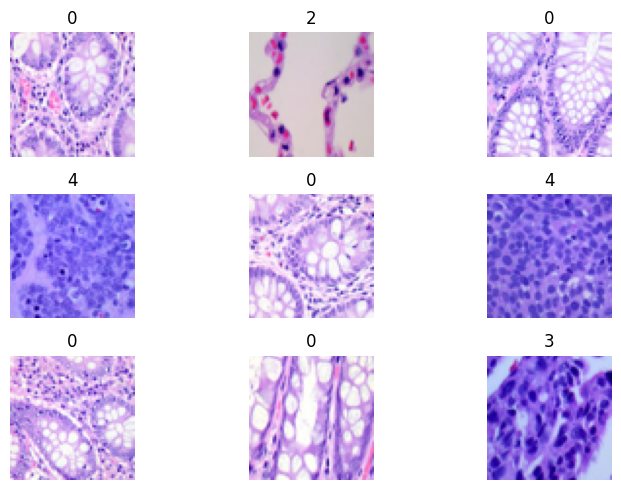

In [4]:
np.random.seed(13)

number_of_samples = 9
random_samples = np.random.randint(0, 
                                   images.shape[0], 
                                   size=(number_of_samples,)
                                  )

#print("Random Index Samples:", random_samples)
random_train_images = images[random_samples]
random_label_images = labels[random_samples]

fig, ax = plt.subplots(nrows = 3, ncols=3, figsize=(8, 5))
cntr=0
l=0
for i in range(3):
    for j in range(3):
        ax[i,j].imshow(random_train_images[cntr])
        ax[i,j].axis("off")
        ax[i,j].set_title(labels[random_samples[l]])
        cntr += 1
        l+=1


plt.tight_layout()
plt.show()

### Splitting the dataset

The total of images that have been loaded in the previous step need to be split into a train and a test set. The first will be used to fit the model and the second to evaluate the results of the fitting. The split that was chosen is 80-20% train-test.

In [5]:
#Choosing what percentage of the train set I want my test set to be
test_size = 0.2

x_train, x_test, y_train, y_test = model_selection.train_test_split(images, 
                                                                    labels,
                                                                    test_size=test_size, 
                                                                    shuffle=True, 
                                                                    random_state=13)

Printing the shapes of both the train and test sets to see the results of the splitting process.

In [6]:
print('The shape of x_train:', x_train.shape)
print('The shape of x_test:', x_test.shape)

The shape of x_train: (20000, 64, 64, 3)
The shape of x_test: (5000, 64, 64, 3)


We can see that the shape of both sets have the format (n, d1, d2, c) where n is the number of images, d1 and d2 the dimensions of the image and c the number of color channels since the images are RGB. 

### Normalizing

We need to normalize both the train and test images to improve stability and performance of the model. Since absolute values and inherent biases are eliminated by normalizing, the model instead learns patterns that are relevant and becomes better at facing variations in the input data.

In [7]:
print(f'Value interval of the train set before the min-max normalization: [{x_train.min()},{x_train.max()}]')
print(f'Value interval of the test set before the min-max normalization:  [{x_test.min()},{x_test.max()}]')

x_train = x_train / 255.0
x_test = x_test / 255.0
print('\n')
print(f'Value interval of the train set after the min-max normalization: [{x_train.min()},{x_train.max()}]')
print(f'Value interval of the test set after the min-max normalization:  [{x_test.min()},{x_test.max()}]')

Value interval of the train set before the min-max normalization: [0,255]
Value interval of the test set before the min-max normalization:  [0,255]


Value interval of the train set after the min-max normalization: [0.0,1.0]
Value interval of the test set after the min-max normalization:  [0.0,1.0]


## CNN
CNNs are mostly used for image data, since convolutional operations detect the patterns that exist in the input images and such patterns can be recognized regardless of where they are located in the image. In the given problem the cells cover the entirety of the image and appear to have characteristics in shape and position that the model can learn to recognize. The pooling layers that are used reduce the spatial dimensions and force the model to retain the features with the highest importance.  

The 'Dropout' layers are used to prevent overfitting. The 'Flatten' layer is used to transform the data into a vector that will then be fed into the fully connected 'Dense' layers that follow to produce the final probability for each class that the image can belong to.

In [8]:
import keras

cnn_model = keras.models.Sequential([keras.layers.Conv2D(filters=32, 
                                                        kernel_size=(3,3), 
                                                        padding="same", 
                                                        activation="relu", 
                                                        input_shape=(64,64,3)), 
                                     keras.layers.MaxPooling2D(pool_size=(2,2)),
                                     keras.layers.Conv2D(filters=64,
                                                        kernel_size=(3,3),
                                                        padding="same",
                                                        activation="relu"),
                                     keras.layers.MaxPooling2D(pool_size=(2,2)),
                                     keras.layers.Conv2D(filters=128,
                                                        kernel_size=(3,3),
                                                        padding="same",
                                                        activation="relu"),    
                                     keras.layers.MaxPooling2D(pool_size=(2,2)),
                                     keras.layers.Dropout(rate=0.25),
                                     keras.layers.Flatten(), 
                                     keras.layers.Dropout(rate=0.5),
                                     keras.layers.Dense(units=256, 
                                                        activation="relu"),
                                     #Using softmax to get the inputs as a probability distribution 
                                     keras.layers.Dense(units=5, 
                                                        activation="softmax")
                                    ]
                                   ) 
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 128)        0

The compilation of the model includes the selection of an optimizer and the metrics used to later evaluate the model. In this case the optimizer that was chosen based on the work mentioned above is 'Adam'. The metric used is 'Accuracy', since the dataset is balanced and it is enough to give an understanding of how well the model is performing.

In [9]:
cnn_model.compile(loss="categorical_crossentropy", 
                             optimizer="adam", 
                             metrics=["accuracy"] 
                            )

### Training the model

The validation set is being extracted from the train set using a 20% split once again.  
The number of epochs has been chosen to be relatively low since according to the bibliography most CNN models seem to converge relatively early on this dataset. A batch of 64 images is suggested.

In [10]:
history = cnn_model.fit(x_train, 
                       keras.utils.to_categorical(y_train),   
                       epochs=50,
                       batch_size=64,
                       validation_split=0.2, 
                       verbose = 0
                      )

### Evaluating the model

The following plots show the 'Cross-Entropy' loss and the 'Accuracy' that are used to assess the model through the different epochs.

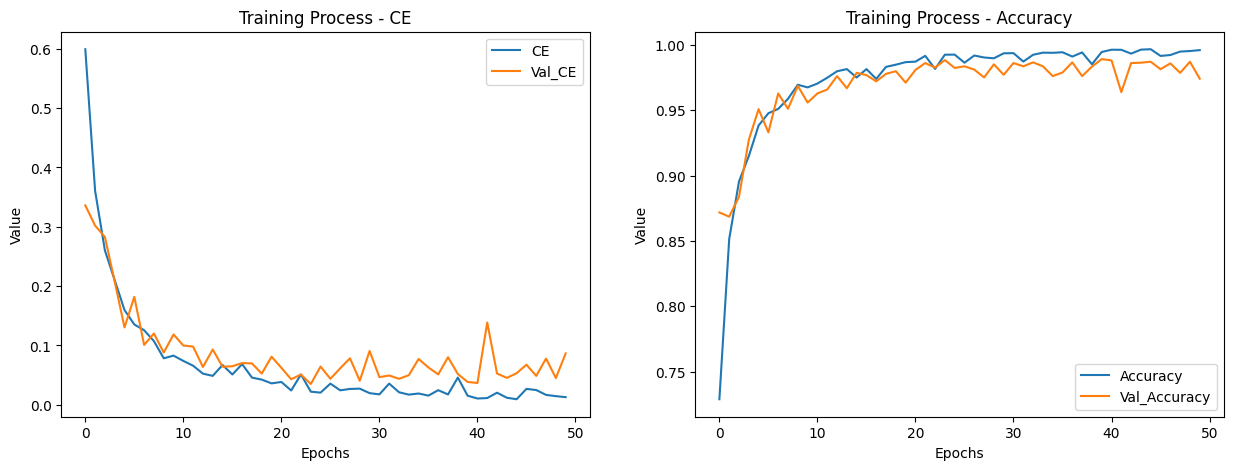

In [11]:
import matplotlib.pyplot as plt

fig, axis = plt.subplots(nrows=1,ncols=2, figsize=(15,5))

axis[0].plot(history.epoch, history.history['loss']) 
axis[0].plot(history.epoch, history.history['val_loss']) 
axis[0].set_xlabel("Epochs") 
axis[0].set_ylabel("Value") 
axis[0].legend(["CE", "Val_CE"]) 
axis[0].set_title("Training Process - CE") 

axis[1].plot(history.epoch, history.history['accuracy'])
axis[1].plot(history.epoch, history.history['val_accuracy'])
axis[1].set_xlabel("Epochs") 
axis[1].set_ylabel("Value") 
axis[1].legend(["Accuracy", "Val_Accuracy"])
axis[1].set_title("Training Process - Accuracy")
plt.show()

The training of the model is being evaluated using 'test accuracy'. The accuracy is derived by comparing the values predicted by the model with the true values of 'y_test'.

In [12]:
#The model makes a prediction with probabilities
predictions_nn_probs = cnn_model.predict(x_test, verbose = 2)

#Each prediction is the maximum of the probabilities
predictions_nn = np.argmax(predictions_nn_probs, axis=1)

test_accuracy_nn = sklearn.metrics.accuracy_score(y_test, predictions_nn)

print("The Accuracy of the Neural Network on the Test Data is", test_accuracy_nn)

157/157 - 4s - 4s/epoch - 27ms/step
The Accuracy of the Neural Network on the Test Data is 0.9742


Finally, a plot of the confusion matrix is created to get a more extensive understanding of the results of the classification that the model has done.

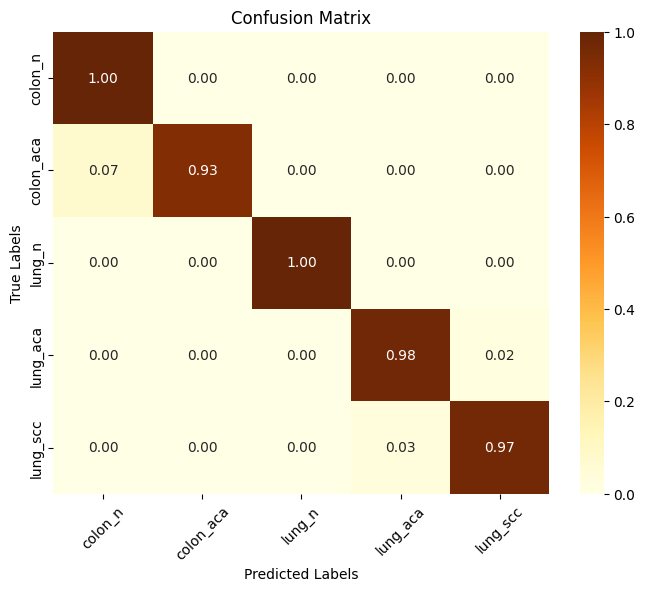

In [14]:
y_pred_labels = np.argmax(predictions_nn_probs, axis=-1)  

class_names = ['colon_n', 'colon_aca', 'lung_n', 'lung_aca', 'lung_scc']

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)


cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a figure and axes
plt.figure(figsize=(8, 6))
ax = plt.axes()

# Plot the confusion matrix
sns.heatmap(cm_normalized, 
            annot=True, 
            fmt=".2f", 
            cmap='YlOrBr', 
            xticklabels=class_names, 
            yticklabels=class_names, 
            ax=ax)

# Set labels, title, and ticks
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)

# Rotate x-axis tick labels if needed
plt.xticks(rotation=45)

# Display the plot
plt.show()

The high accuracy score already indicated that the classification was extremely successful. It is also evident on the confusion matrix that for all five of the classes the labels that were correctly predicted are nearing 100%. The lowest percentage(95%) appears on the 'Lung adenocarcinoma' class that had some of its images be classified as 'Lung squamous cells'. Both subclasses belong to the 'Lung' class and both are types of cancerous cells, which appear to have some slight similarities that could account for the false predictions.

## Conclusion
The classification of histopathological images is a task that seems to be achieved by relatively simple CNNs. Previous research has shown that even higher scores can be achieved by incorporating more extensive preprocessing steps, using hybrid models that leverage the strengths of each individual approach and including a soft voting classifier among others. Models that achieve such high rates can prove useful in the medical and clinical field by assisting the process of diagnosing and perhaps even eliminating human error further down the road.